In [1]:
%%capture
!pip install -r requirement.txt;

In [2]:
import numpy as np
import geatpy as ea
import pandas as pd
import random
from datetime import datetime
pd.set_option('display.max_columns', 500) # show all columns
print(ea.__version__)

debug = 1 # debug mode

2.7.0


### PARAMETER INPUT

TODO: check input validation

The elements in list must be in order.

In [3]:
# boolen
NbvCost = True # True: max nbv; False: min cost

# float
minTotalNbv = 1000000
maxTotalNbv = 100000000

# float
minTotalCost = 1000000
maxTotalCost = 100000000

# float
fleetAgeLowBound = [3, 6, 9]
fleetAgeUpBound = [6, 9, 12]
fleetAgeLimit = [0., 0., 0.]

# float
OnHireLimit = 0.

# float
weightedAgeLowBound = [2.5, 4, 4.5]
weightedAgeUpBound = [3.6, 4.5, 5.2]
weightedAgeLimit = [0., 0., 0.]

# string
productType = ['D40', 'D20', 'R40']
# float
productLimit = [0., 0., 0.]

# string
lesseeType = ['MSC', 'ONE', 'HAPAG']
# float
lesseeLimit = [0., 0., 0.]

# string
contractType = ['LE', 'LF', 'LT']
# float
contractLimit = [0., 0., 0.]

### READ DATA
TODO: read data from GP

In [4]:
rawData = pd.read_excel(io='./FCI ANZ (2022-07-08) (NBV as at 30 Jun 2022)_v2.xlsx', sheet_name='Raw (portfolio)', engine='openpyxl')

In [4]:
# randomly choose n samples
n = 1000

In [9]:
rawData = rawData.iloc[:30000, :61]

In [10]:
data = rawData.sample(n)
print(data.shape)
data.sample(3)

(1000, 61)


,Business Unit (Contract),Business Unit Am,Unit Id Fz,Cost,Po Num Fz,Mfr Dt Fz,Asset Id,Pool Fz,Product,Birth Unit Id Fz,Owner,Teu Fz,Ceu Fz,Contract Cust Id,Contract Num,Contract Dt,Contract Expiration Dt,Contract Lease Type,Contract Currency,Exchange Rate,Per Diem Rate (Max),Per Diem Rate (Max) in USD,Contract Rate Type (Min),Per Diem Rate (Min),Per Diem Rate (Min) in USD,Buy Out Amt Fz,Monthly Depr,Depre adjustment,Nbv,Life Status Fz,Billing Status Fz,Move Status Fz,Move Type Fz,Inv Status Fz,Fleet Year Fz,Financing Cd,Asset Status,Lessor,Remaining Lease Term,Age x CEU,RML x CEU,Mfr Year,Reserve Code Fz,Remaining Lease Term(C),RML x CEU(C),Chk on RML validity(HAPAG),Expiry year,Expiry month,Chk on RML validity(12 YR),Planned,Entity,Correct CEU,NP year,NBV check,age at drawdown X CEU,RML at drawdown X CEU,category,string,filter 2017 contracts,contract units,filter no. of units
13438,FZOPS,DF3RM,FFAU4072315,6007.0,SMSL-FL-2105,4/28/2021,1722628.0,DFC3,D4H,FFAU4072315,Dong Fang,2.0,1.7,MSC,LT-MSC-48,2021-04-01,2029-06-30,LT,USD,1.0,1.95,1.95,FR,1.95,1.95,720.0,-27.73,0.0,5618.80,AC,ON,GO,RLI,AVA,1.17,NaN,I,FUSBI,7.008219,1.989,11.913973,2021.0,F - FL / < 8 yrs,7.008219,11.913973,0.0,2029.0,6.0,8.178219,FCI ANZ 100M,FCI,1.7,2021 NP,Reasonable,3.265164,10.637808,from ANZ portfolio,LT-MSC-48D4H,NaN,6997.0,1.0
9802,FZOPS,DF3RM,FFAU3675356,4420.0,DFIC-FL-2104,3/24/2021,1700082.0,DFC3,D4H,FFAU3675356,Dong Fang,2.0,1.7,ONE,LE-ONE-09A,2020-11-16,2029-05-15,LT,USD,1.0,1.25,1.25,ST,0.63,0.63,0.0,-18.91,0.0,4136.34,AC,ON,GO,RLI,AVA,1.27,NaN,I,FUSBI,6.882192,2.159,11.699726,2021.0,F - OL / < 8 yrs,6.882192,11.699726,0.0,2029.0,5.0,8.152192,FCI ANZ 100M,FCI,1.7,2021 NP,Reasonable,3.435164,10.423562,from ANZ portfolio,LE-ONE-09AD4H,NaN,2000.0,1.0
14709,FZOPS,DF3RM,FFAU4039261,6000.0,CSIH-FL-2115,4/8/2021,1706823.0,DFC3,D4H,FFAU4039261,Dong Fang,2.0,1.7,MSC,LT-MSC-48,2021-04-01,2029-06-30,LT,USD,1.0,1.95,1.95,FR,1.95,1.95,720.0,-27.69,0.0,5612.35,AC,ON,GO,RLI,AVA,1.23,NaN,I,FUSBI,7.008219,2.091,11.913973,2021.0,F - FL / < 8 yrs,7.008219,11.913973,0.0,2029.0,6.0,8.238219,FCI ANZ 100M,FCI,1.7,2021 NP,Reasonable,3.367164,10.637808,from ANZ portfolio,LT-MSC-48D4H,NaN,6997.0,1.0


### DATA PREPARATION

In [11]:
input_data = \
    data.loc[:, ['Cost', 'Mfr Dt Fz', 'Product', 'Contract Cust Id', 'Contract Dt', 'Contract Expiration Dt', \
                 'Nbv', 'Billing Status Fz', 'Fleet Year Fz', 'Age x CEU', 'Contract Lease Type']]
input_data.head(3)

,Cost,Mfr Dt Fz,Product,Contract Cust Id,Contract Dt,Contract Expiration Dt,Nbv,Billing Status Fz,Fleet Year Fz,Age x CEU,Contract Lease Type
22622,2267.0,3/22/2018,D20,ONE,2018-02-01,2026-10-14,1888.000,ON,4.27,4.270,LE
776,3832.0,12/18/2017,D4H,HAPAG,2017-11-01,2030-01-31,2981.834,ON,4.53,7.701,LF
14912,6000.0,4/8/2021,D4H,MSC,2021-04-01,2029-06-30,5612.350,ON,1.23,2.091,LT


#### Container Age

Assign to `FleetAge1`, `FleetAge2`, `FleetAge3`

In [12]:
def SelectFleetAge(age, i):
    if fleetAgeLowBound[i] <= age < fleetAgeUpBound[i]:
        age = 1
    else:
        age = 0
    return age

input_data['FleetAge1'] = input_data.apply(lambda x: SelectFleetAge(x['Fleet Year Fz'], 0), axis=1)
input_data['FleetAge2'] = input_data.apply(lambda x: SelectFleetAge(x['Fleet Year Fz'], 1), axis=1)
input_data['FleetAge3'] = input_data.apply(lambda x: SelectFleetAge(x['Fleet Year Fz'], 2), axis=1)
input_data.sample(3)

,Cost,Mfr Dt Fz,Product,Contract Cust Id,Contract Dt,Contract Expiration Dt,Nbv,Billing Status Fz,Fleet Year Fz,Age x CEU,Contract Lease Type,FleetAge1,FleetAge2,FleetAge3
13385,6007.0,4/28/2021,D4H,MSC,2021-04-01,2029-06-30,5618.800,ON,1.17,1.989,LT,0,0,0
20708,3849.0,4/6/2018,D4H,ONE,2018-02-01,2026-10-14,3123.453,ON,4.23,7.191,LE,1,0,0
6271,3682.0,1/1/2018,D4H,MSC,2018-03-01,2032-07-31,2933.000,ON,4.49,7.633,LT,1,0,0


#### Status

Assign new column `Status`

In [13]:
def SelectStatus(status):
    if status == 'ON':
        status = 1
    else:
        status = 0
    return status

input_data['Status'] = input_data.apply(lambda x: SelectStatus(x['Billing Status Fz']), axis=1)
input_data.sample(3)

,Cost,Mfr Dt Fz,Product,Contract Cust Id,Contract Dt,Contract Expiration Dt,Nbv,Billing Status Fz,Fleet Year Fz,Age x CEU,Contract Lease Type,FleetAge1,FleetAge2,FleetAge3,Status
12004,4420.0,3/3/2021,D4H,ONE,2020-11-16,2029-05-15,4117.43,ON,1.32,2.244,LT,0,0,0,1
7026,3682.0,1/1/2018,D4H,TCLC,2018-02-01,2025-05-31,2917.31,ON,4.49,7.633,LT,1,0,0,1
26745,3682.0,1/1/2018,D4H,HAPAG,2017-11-01,2030-01-31,2869.54,ON,4.49,7.633,LF,1,0,0,1


#### Weighted Age

Assign new column `WeightedAge1`, `WeightedAge2`, `WeightedAge3`

In [14]:
def SelectWeightedAge(age, i):
    if weightedAgeLowBound[i] <= age < weightedAgeUpBound[i]:
        age = 1
    else:
        age = 0
    return age

input_data['WeightedAge1'] = input_data.apply(lambda x: SelectWeightedAge(x['Age x CEU'], 0), axis=1)
input_data['WeightedAge2'] = input_data.apply(lambda x: SelectWeightedAge(x['Age x CEU'], 1), axis=1)
input_data['WeightedAge3'] = input_data.apply(lambda x: SelectWeightedAge(x['Age x CEU'], 2), axis=1)
input_data.sample(3)

,Cost,Mfr Dt Fz,Product,Contract Cust Id,Contract Dt,Contract Expiration Dt,Nbv,Billing Status Fz,Fleet Year Fz,Age x CEU,Contract Lease Type,FleetAge1,FleetAge2,FleetAge3,Status,WeightedAge1,WeightedAge2,WeightedAge3
5799,3682.0,1/1/2018,D4H,MSC,2018-03-01,2032-07-31,2933.000,ON,4.49,7.633,LT,1,0,0,1,0,0,0
12405,4420.0,3/3/2021,D4H,ONE,2020-11-16,2029-05-15,4117.430,ON,1.32,2.244,LT,0,0,0,1,0,0,0
29096,2182.0,1/2/2018,D20,HAPAG,2017-11-01,2030-01-31,1784.484,ON,4.49,4.490,LF,1,0,0,1,0,1,0


#### Product

Assign new column `ProductType1`, `ProductType2`, `ProductType3`

In [15]:
def SelectProductType(product, i):
    if product == productType[i]:
        product = 1
    else:
        product = 0
    return product

input_data['ProductType1'] = input_data.apply(lambda x: SelectProductType(x['Product'], 0), axis=1)
input_data['ProductType2'] = input_data.apply(lambda x: SelectProductType(x['Product'], 1), axis=1)
input_data['ProductType3'] = input_data.apply(lambda x: SelectProductType(x['Product'], 2), axis=1)
input_data.sample(3)

,Cost,Mfr Dt Fz,Product,Contract Cust Id,Contract Dt,Contract Expiration Dt,Nbv,Billing Status Fz,Fleet Year Fz,Age x CEU,Contract Lease Type,FleetAge1,FleetAge2,FleetAge3,Status,WeightedAge1,WeightedAge2,WeightedAge3,ProductType1,ProductType2,ProductType3
22393,2267.0,3/22/2018,D20,ONE,2018-02-01,2026-10-14,1888.00,ON,4.27,4.270,LE,1,0,0,1,0,1,0,0,1,0
25745,2262.0,3/21/2018,D20,ONE,2018-02-01,2026-10-14,1884.21,ON,4.27,4.270,LE,1,0,0,1,0,1,0,0,1,0
14165,6000.0,4/8/2021,D4H,MSC,2021-04-01,2029-06-30,5612.35,ON,1.23,2.091,LT,0,0,0,1,0,0,0,0,0,0


#### Lessee

Assign new column `Lessee1`, `Lessee2`, `Lessee3`

In [16]:
def SelectLessee(lessee, i):
    if lessee == lesseeType[i]:
        lessee = 1
    else:
        lessee = 0
    return lessee

input_data['Lessee1'] = input_data.apply(lambda x: SelectLessee(x['Contract Cust Id'], 0), axis=1)
input_data['Lessee2'] = input_data.apply(lambda x: SelectLessee(x['Contract Cust Id'], 1), axis=1)
input_data['Lessee3'] = input_data.apply(lambda x: SelectLessee(x['Contract Cust Id'], 2), axis=1)
input_data.sample(3)

,Cost,Mfr Dt Fz,Product,Contract Cust Id,Contract Dt,Contract Expiration Dt,Nbv,Billing Status Fz,Fleet Year Fz,Age x CEU,Contract Lease Type,FleetAge1,FleetAge2,FleetAge3,Status,WeightedAge1,WeightedAge2,WeightedAge3,ProductType1,ProductType2,ProductType3,Lessee1,Lessee2,Lessee3
8093,3702.0,6/11/2018,D4H,MSC,2018-03-01,2032-07-31,2967.91,ON,4.05,6.885,LT,1,0,0,1,0,0,0,0,0,0,1,0,0
27049,3682.0,1/1/2018,D4H,HAPAG,2017-11-01,2030-01-31,2869.54,ON,4.49,7.633,LF,1,0,0,1,0,0,0,0,0,0,0,0,1
1802,3832.0,12/18/2017,D4H,HAPAG,2017-11-01,2030-01-31,2981.80,ON,4.53,7.701,LF,1,0,0,1,0,0,0,0,0,0,0,0,1


#### Contract Type

Assign new column `ContractType1`, `ContractType2`, `ContractType3`

In [17]:
input_data['Contract Lease Type']

22622    LE
776      LF
14912    LT
4295     LT
4830     LT
         ..
18741    LT
20207    LE
19470    LE
11862    LT
10027    LT
Name: Contract Lease Type, Length: 1000, dtype: object

In [18]:
def SelectContractType(contract, i):
    if str(contract) == contractType[i]:
        contract = 1
    else:
        contract = 0
    return contract

input_data['ContractType1'] = input_data.apply(lambda x: SelectContractType(x['Contract Lease Type'], 0), axis=1)
input_data['ContractType2'] = input_data.apply(lambda x: SelectContractType(x['Contract Lease Type'], 1), axis=1)
input_data['ContractType3'] = input_data.apply(lambda x: SelectContractType(x['Contract Lease Type'], 2), axis=1)
input_data.sample(3)

,Cost,Mfr Dt Fz,Product,Contract Cust Id,Contract Dt,Contract Expiration Dt,Nbv,Billing Status Fz,Fleet Year Fz,Age x CEU,Contract Lease Type,FleetAge1,FleetAge2,FleetAge3,Status,WeightedAge1,WeightedAge2,WeightedAge3,ProductType1,ProductType2,ProductType3,Lessee1,Lessee2,Lessee3,ContractType1,ContractType2,ContractType3
9117,5150.0,4/20/2021,D4H,MSC,2021-04-01,2029-06-30,4773.96,ON,1.19,2.023,LT,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
28520,3682.0,1/3/2018,D4H,HAPAG,2017-11-01,2030-01-31,2869.54,ON,4.49,7.633,LF,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0
12222,4420.0,3/3/2021,D4H,ONE,2020-11-16,2029-05-15,4117.43,ON,1.32,2.244,LT,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1


### SAVE DATA

In [19]:
input_data.to_csv('prepared_data_demo.csv')

In [5]:
prepared_data = pd.read_csv('./prepared_data_demo.csv')
prepared_data.head(3)

,Unnamed: 0,Cost,Mfr Dt Fz,Product,Contract Cust Id,Contract Dt,Contract Expiration Dt,Nbv,Billing Status Fz,Fleet Year Fz,Age x CEU,Contract Lease Type,FleetAge1,FleetAge2,FleetAge3,Status,WeightedAge1,WeightedAge2,WeightedAge3,ProductType1,ProductType2,ProductType3,Lessee1,Lessee2,Lessee3,ContractType1,ContractType2,ContractType3
0,22622,2267.0,3/22/2018,D20,ONE,2018-02-01,2026-10-14,1888.000,ON,4.27,4.270,LE,1,0,0,1,0,1,0,0,1,0,0,1,0,1,0,0
1,776,3832.0,12/18/2017,D4H,HAPAG,2017-11-01,2030-01-31,2981.834,ON,4.53,7.701,LF,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0
2,14912,6000.0,4/8/2021,D4H,MSC,2021-04-01,2029-06-30,5612.350,ON,1.23,2.091,LT,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1


### Model Part

In [6]:
nbv = prepared_data['Nbv'].to_numpy().reshape(n, 1)
cost = prepared_data['Cost'].to_numpy().reshape(n, 1)
fleetAge = np.stack([prepared_data['FleetAge1'].to_numpy(),
                     prepared_data['FleetAge2'].to_numpy(),
                     prepared_data['FleetAge3'].to_numpy()]).reshape(3, n, 1)
status = prepared_data['Status'].to_numpy().reshape(n, 1)
weightedAge = np.stack([prepared_data['WeightedAge1'].to_numpy(),
                        prepared_data['WeightedAge2'].to_numpy(),
                        prepared_data['WeightedAge3'].to_numpy()]).reshape(3, n, 1)
productType = np.stack([prepared_data['ProductType1'].to_numpy(),
                        prepared_data['ProductType2'].to_numpy(),
                        prepared_data['ProductType3'].to_numpy()]).reshape(3, n, 1)
lessee = np.stack([prepared_data['Lessee1'].to_numpy(),
                   prepared_data['Lessee2'].to_numpy(),
                   prepared_data['Lessee3'].to_numpy()]).reshape(3, n, 1)
contractType = np.stack([prepared_data['ContractType1'].to_numpy(),
                         prepared_data['ContractType2'].to_numpy(),
                         prepared_data['ContractType3'].to_numpy(),]).reshape(3, n, 1)
if debug:
    print('nbv shape: ', nbv.shape)
    print('cost shape:', cost.shape)
    print('fleetAge shape: ', fleetAge.shape)
    print('status shape:', status.shape)
    print('weightedAge shape:', weightedAge.shape)
    print('productType shape:', productType.shape)
    print('lessee shape:', lessee.shape)
    print('contractType shape:', contractType.shape)

nbv shape:  (1000, 1)
cost shape: (1000, 1)
fleetAge shape:  (3, 1000, 1)
status shape: (1000, 1)
weightedAge shape: (3, 1000, 1)
productType shape: (3, 1000, 1)
lessee shape: (3, 1000, 1)
contractType shape: (3, 1000, 1)


#### Constraints

`x`: np.array, size=num_of_container. `x[i]=1` stands for $i^{th}$ container is selected; `x[i]=0` stands for $i^{th}$ container is not selected.

1. minTotalNbv <= Total NBV <= maxTotalNbv
    
2. minTotalCost <= Total Cost <= maxTotalCost
    
3. Container Age
    
4. Status:

    1. OnHire >= OnHireLimit

5. Weighted Age

6. Product
    
7. Lessee
    
8. Contract Type


#### Objective

1. min Cost: `Vars @ cost`

2. max Nbv: `Vars @ nbv`

#### Define Problem
Define objective function and constraint functions

In [13]:
def DEMO():
    class MyProblem(ea.Problem):
        def __init__(self):
            name ='MyProblem'
            M = 1
            maxormins = [-1 if NbvCost else 1] # -1: max, 1: min
            Dim = n # num of variables
            varTypes = [1] * Dim # integers: 0 or 1
            lb = [0] * Dim # low bound
            ub = [1] * Dim # up bound
            lbin = [1] * Dim # low bound include
            ubin = [1] * Dim # up bound include
            ea.Problem.__init__(self, name, M, maxormins, Dim, varTypes, lb,ub, lbin, ubin)
            
        def aimFunc(self, pop):
            Vars = pop.Phen
            
            # objective function
            pop.ObjV = Vars @ nbv if NbvCost else Vars @ cost

            numSelectedContainer = Vars.sum(axis=1, keepdims=True)

            # constraints functions
            pop.CV = np.hstack([
                # NBV
                -(Vars @ nbv - minTotalNbv),
                Vars @ nbv - maxTotalNbv,
                # Cost
                -(Vars @ cost - minTotalCost),
                Vars @ cost - maxTotalCost,
                # Container age
                -((Vars @ fleetAge[0]) / numSelectedContainer - fleetAgeLimit[0]),
                -((Vars @ fleetAge[1]) / numSelectedContainer - fleetAgeLimit[1]),
                -((Vars @ fleetAge[2]) / numSelectedContainer - fleetAgeLimit[2]),
                # Status
                -((Vars @ status) / numSelectedContainer - OnHireLimit),
                # Weighted age
                -((Vars @ weightedAge[0]) / numSelectedContainer - weightedAgeLimit[0]),
                -((Vars @ weightedAge[1]) / numSelectedContainer - weightedAgeLimit[1]),
                -((Vars @ weightedAge[2]) / numSelectedContainer - weightedAgeLimit[2]),
                # Product
                -((Vars @ productType[0]) / numSelectedContainer - productLimit[0]),
                -((Vars @ productType[1]) / numSelectedContainer - productLimit[1]),
                -((Vars @ productType[2]) / numSelectedContainer - productLimit[2]),
                # Lessee
                -((Vars @ lessee[0]) / numSelectedContainer - lesseeLimit[0]),
                -((Vars @ lessee[1]) / numSelectedContainer - lesseeLimit[1]),
                -((Vars @ lessee[2]) / numSelectedContainer - lesseeLimit[2]),
                # Contract type
                -((Vars @ contractType[0]) / numSelectedContainer - contractLimit[0]),
                -((Vars @ contractType[1]) / numSelectedContainer - contractLimit[1]),
                -((Vars @ contractType[2]) / numSelectedContainer - contractLimit[2]),
            ])


    problem = MyProblem()
    Encoding ='RI'
    NIND = 100 # init number of population instance
    Field = ea.crtfld(Encoding, problem.varTypes, problem.ranges,problem.borders)
    population = ea.Population(Encoding, Field, NIND)

    # set parameters
    myAlgorithm = ea.soea_DE_best_1_L_templet(problem, population)
    myAlgorithm.MAXGEN = 10000
    myAlgorithm.mutOper.F = 0.5
    myAlgorithm.recOper.XOVR = 0.7 # probability of chrom crossover
    myAlgorithm.logTras = 1 # record log each logTras generations
    myAlgorithm.trappedValue = 1e-6
    myAlgorithm.maxTrappedCount = 1000 # TODO: increase it or remove it

    # TODO: random seed has a significant influence on final result!
    # outputMsg=True to show the result
    res = ea.optimize(myAlgorithm, seed=2049, verbose=False, drawing=1, outputMsg=True, drawLog=False, saveFlag=False, dirName='result')
    if debug:
        print(res)
    return res

0.959, 0.974, 0.995, 

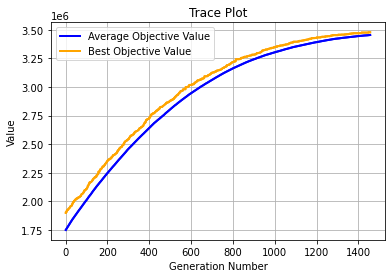

Execution time: 9.325923919677734 s
Evaluation number: 145600
The best objective value is: 3478773.4859999996
The best variables are: 
1	1	0	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	0	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	0	1	1	1	1	1	1	1	1	1	1	1	1	1	1	0	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	0	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1

In [14]:
selectedPackage = DEMO()

`NIND` barely has any influence on the final result, but will slow down the process. -- what about reduce to 100

`maxTrappedCount` has a big influence on the final result. U should try to increase maxTrappedCount to gain better performance.

#### Output

1000 gen = 13 minutes
No early stop if no feasible result is found.


In [15]:
print('Time Consumption: ', np.round(selectedPackage['executeTime'], decimals=2), 's')
print(selectedPackage['stopMsg'])

if selectedPackage['success']:
    print('Algorithm Succeeded!')
    print('===================================================================================================')
    print('Optimal Target Value: ', np.round(selectedPackage['ObjV'].item(), decimals=2))
    print('Constraint Violation: ', np.round(selectedPackage['CV'][0], decimals=2))
    if debug:
        # TODO: doing
        print('===================================================================================================')
        Vars = selectedPackage['Vars'][0]
else:
    print('No Feasible Results...')

Time Consumption:  9.33 s
The algotirhm stepped because it exceeded the trapped count limit.
Algorithm Succeeded!
Optimal Target Value:  3478773.49
Constraint Violation:  [-2.47877349e+06 -9.65212265e+07 -3.01416240e+06 -9.59858376e+07
 -6.30000000e-01 -0.00000000e+00 -0.00000000e+00 -1.00000000e+00
 -0.00000000e+00 -2.00000000e-01 -0.00000000e+00 -0.00000000e+00
 -2.00000000e-01 -0.00000000e+00 -4.30000000e-01 -3.60000000e-01
 -1.90000000e-01 -2.50000000e-01 -1.90000000e-01 -5.70000000e-01]


In [16]:
# print final result
print('Selected Package:')
print('===================================================================================================')
print(len(selectedPackage['Vars'].nonzero()[1]), '/', n, 'containers selected.')
print(selectedPackage['Vars'].nonzero()[1]) # index begins from 0
print('===================================================================================================')
print(selectedPackage['Vars'][0].tolist())

Selected Package:
988 / 1000 containers selected.
[  0   1   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 142 143 144 145 146
 147 148 149 150 151 152 153 154 155 157 158 159 160 161 162 163 164 165
 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183
 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201
 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219
 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237
 